In [3]:
import observational_fear.load as load
from observational_fear.events import get_block_starts
from neurobox.wide_transforms import resample
from pathlib import Path
import pandas as pd
import numpy as np
from binit.align import align_around
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from observational_fear.events import get_freeze_starts
from neurobox.long_transforms import align_to_events
from observational_fear.nbox_transforms import align_to_data_by, exclude_short_trials
from scipy.ndimage import gaussian_filter1d
import os


sns.set_style("whitegrid")


DATA_DIR = Path(r"F:\OFL\one-p experiment\data")

FIG_DIR = Path(os.getcwd()).parent / "figs"
FIG_DIR.mkdir(exist_ok=True)
FIG_DIR


WindowsPath('c:/Users/roryl/repos/observational-fear/figs')

# Day 2

In [33]:
SESSION = "day2"
df_freeze = load.load_freeze(DATA_DIR, session=SESSION)
block_day2 = pd.read_csv(DATA_DIR / "day2-block-responders.csv")
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")
df = df.reset_index().melt(id_vars=["time"])


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


#### CS

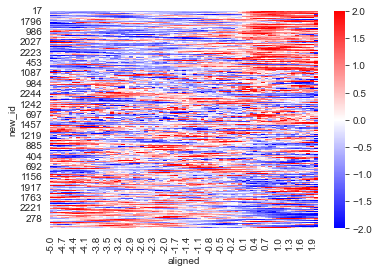

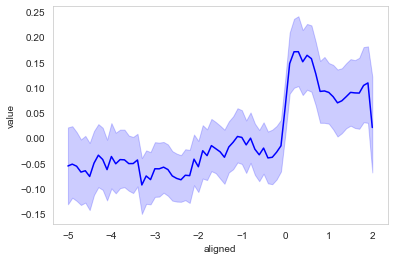

In [34]:
cs_stats = get_block_starts(session="day2", block_name="CS")
idx = (
    block_day2.loc[lambda x: x.block == "CS"]
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    df.copy()
    .assign(
        aligned=lambda x: np.round(
            align_around(x["time"].values, cs_stats, t_before=5, max_latency=2), 1
        )
    )
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)[idx]

plt.figure()
sns.heatmap(dfp.transpose(), vmin=-2, vmax=2, cmap="bwr")
# dfp.transpose().to_csv(FIG_DIR / "HeatData CS day2.csv")

# plt.savefig(FIG_DIR/ "Heat CS day2.png", dpi=300)


plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="blue",
)
plt.grid(b=None)
# plt.savefig(FIG_DIR / "Line CS day2.svg")

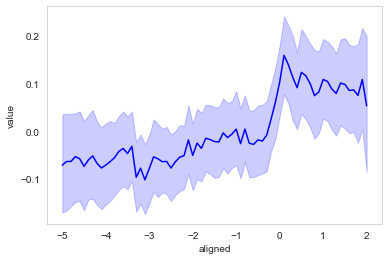

In [15]:
coreg_cells = pd.read_csv("coregistered_nofreeze.csv")["new_id"].unique().astype(str)


plt.figure()
sns.lineplot(
    data=dfp[coreg_cells].reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="blue",
)
plt.grid(b=None)

plt.savefig(FIG_DIR / "Line CS day2 Coreg only.svg")

#### US

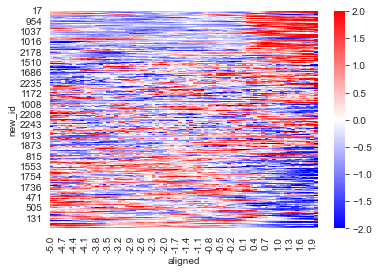

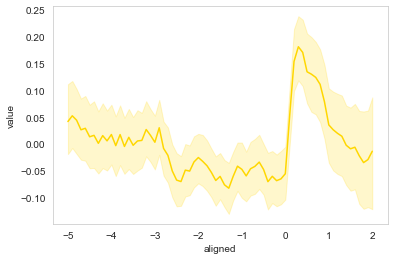

In [23]:
us_stats = get_block_starts(session="day2", block_name="US")
idx = (
    block_day2.loc[lambda x: x.block == "US"]
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    df.copy()
    .assign(
        aligned=lambda x: np.round(
            align_around(x["time"].values, us_stats, t_before=5, max_latency=2), 1
        )
    )
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)[idx]

plt.figure()
sns.heatmap(dfp.transpose(), vmin=-2, vmax=2, cmap="bwr")
dfp.transpose().to_csv(FIG_DIR / "HeatData US day2.csv")
plt.savefig(FIG_DIR / "Heat US day2.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="gold",
)
plt.grid(b=None)
plt.savefig(FIG_DIR / "Line US day2.svg")



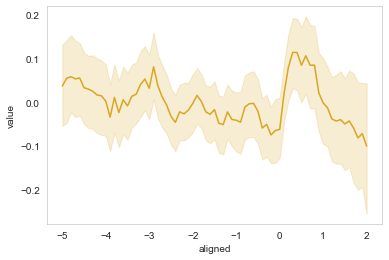

In [24]:
plt.figure()
sns.lineplot(
    data=dfp[coreg_cells].reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="goldenrod",
)
plt.grid(b=None)

plt.savefig(FIG_DIR / "Line US day2 Coreg only.svg")

c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_latency=max_latency,
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\df_grouping_utils\multiple_df_groupby.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_result["group"] = group
c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

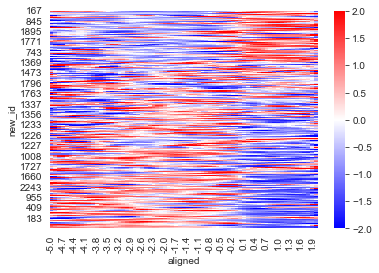

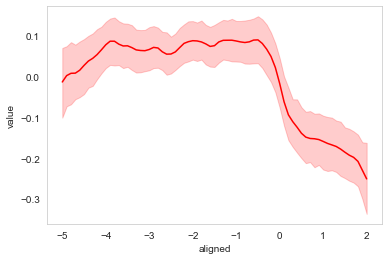

In [18]:
# observer starts

results_day2_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing_obs", mouse_col="mouse_name"
)

df_events = events_day2_freeze_starts.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=1,
)

traces_day2_freeze_starts = exclude_short_trials(traces_day2_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_starts
    .sort_values("diff_of_medians_obs")["new_id"]
    .values.astype(str)
)
dfp = (
    traces_day2_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-2, vmax=2, cmap="bwr")
dfp.transpose().to_csv(FIG_DIR / "HeatData Observer Starts day2.csv")
plt.savefig(FIG_DIR / "Heat freeze starts observer day2.png", dpi=300)


plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="red",
)
plt.grid(b=None)
plt.savefig(FIG_DIR / "Line freeze starts observer day2.svg")


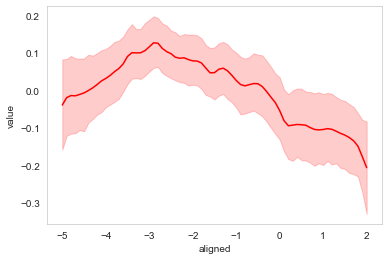

In [19]:
plt.figure()
sns.lineplot(
    data=dfp[coreg_cells].reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="red",
)
plt.grid(b=None)

plt.savefig(FIG_DIR / "Line freeze start day2 Coreg only.svg")

c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_latency=max_latency,
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\df_grouping_utils\multiple_df_groupby.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_result["group"] = group
c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

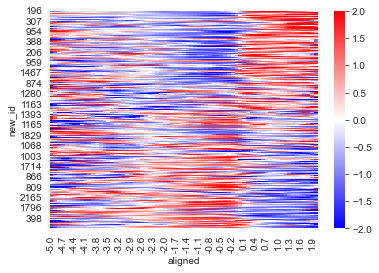

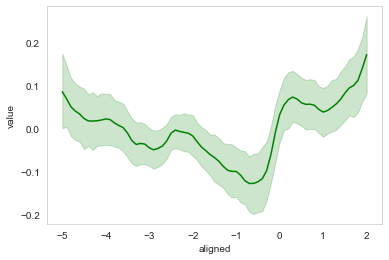

In [20]:
# observer stops
from observational_fear.events import get_freeze_stops

results_day2_freeze_stops = pd.read_csv(DATA_DIR / "freeze_stops_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_stops = get_freeze_stops(
    df_freeze, freeze_col="was_freezing_obs", mouse_col="mouse_name"
)

df_events = events_day2_freeze_stops.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_stops = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_stop",
    df_events_group_colname="mouse",
    precision=1,
)
traces_day2_freeze_stops = exclude_short_trials(traces_day2_freeze_stops,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_stops
    .sort_values("diff_of_medians_obs")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day2_freeze_stops.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-2, vmax=2, cmap="bwr")
dfp.transpose().to_csv(FIG_DIR / "HearData Observer Stops day2.csv")
plt.savefig(FIG_DIR / "Heat freeze stops observer day2.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="green",
)
plt.grid(b=None)
plt.savefig(FIG_DIR / "Line freeze stops observer day2.svg")

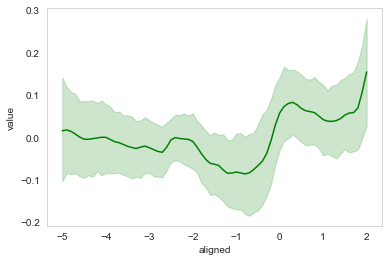

In [22]:
plt.figure()
sns.lineplot(
    data=dfp[coreg_cells].reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="green",
)
plt.grid(b=None)

plt.savefig(FIG_DIR / "Line freeze stop day2 Coreg only.svg")

c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_latency=max_latency,
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\df_grouping_utils\multiple_df_groupby.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_result["group"] = group
c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

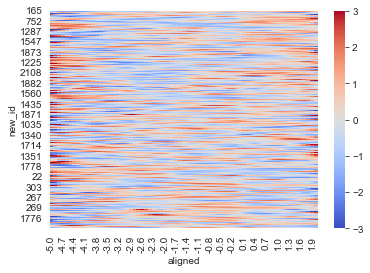

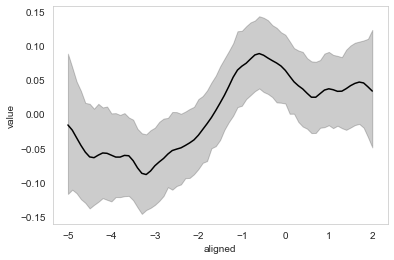

In [7]:
# dem starts

results_day2_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing_dem", mouse_col="mouse_name"
)

df_events = events_day2_freeze_starts.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=1,
)
traces_day2_freeze_starts = exclude_short_trials(traces_day2_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_starts
    .sort_values("diff_of_medians_dem")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day2_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze starts demonstrator day2.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.grid(b=None)

plt.savefig("Line freeze starts demonstrator day2.svg")


c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_latency=max_latency,
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\df_grouping_utils\multiple_df_groupby.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_result["group"] = group
c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

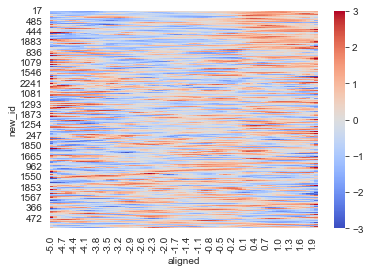

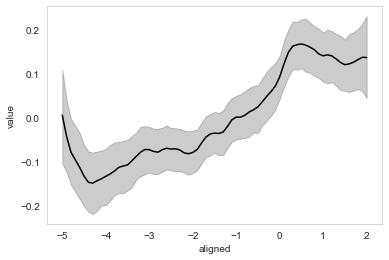

In [8]:
results_day2_freeze_stops = pd.read_csv(DATA_DIR / "freeze_stops_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_stops = get_freeze_stops(
    df_freeze, freeze_col="was_freezing_dem", mouse_col="mouse_name"
)

df_events = events_day2_freeze_stops.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_stops = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_stop",
    df_events_group_colname="mouse",
    precision=1,
)
traces_day2_freeze_stops = exclude_short_trials(traces_day2_freeze_stops,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_stops
    .sort_values("diff_of_medians_dem")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day2_freeze_stops.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze stops demonstrator.svg")

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.grid(b=None)

plt.savefig("Line freeze stops demonstrator day2.svg")

# Day 4

In [25]:
SESSION = "day4"
df_freeze = load.load_freeze(DATA_DIR, session=SESSION)

In [26]:
block_day4 = pd.read_csv(DATA_DIR / "day4-block-responders.csv")
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")
df = df.reset_index().melt(id_vars=["time"])


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


In [27]:
block_day2 = pd.read_csv(DATA_DIR / "day2-block-responders.csv")
block_day4_d2cells = block_day2.merge(block_day4[["new_id"]])

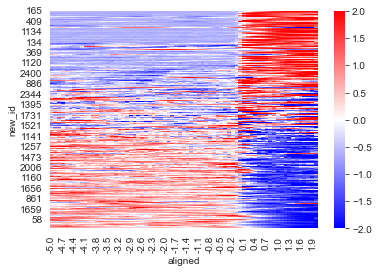

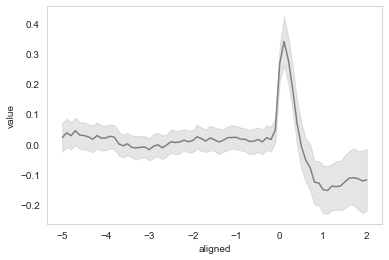

In [28]:
us_stats = get_block_starts(session="day4", block_name="US")
idx = (
    block_day4.loc[lambda x: x.block == "US"]
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    df.copy()
    .assign(
        aligned=lambda x: np.round(
            align_around(x["time"].values, us_stats, t_before=5, max_latency=2), 1
        )
    )
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)[idx]

plt.figure()
sns.heatmap(dfp.transpose(), vmin=-2, vmax=2, cmap="bwr")
dfp.transpose().to_csv(FIG_DIR / "HeatData US day4")
plt.savefig(FIG_DIR / "Heat US day4.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="grey",
)
plt.grid(b=None)

plt.savefig(FIG_DIR / "Line US day4.svg")



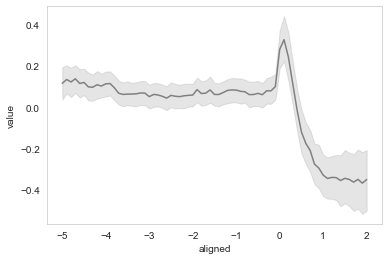

In [29]:
plt.figure()
sns.lineplot(
    data=dfp[coreg_cells].reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="grey",
)
plt.grid(b=None)

plt.savefig(FIG_DIR / "Line US day4 Coreg only.svg")

c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_latency=max_latency,
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\df_grouping_utils\multiple_df_groupby.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_result["group"] = group
c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

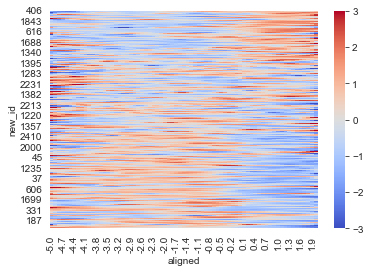

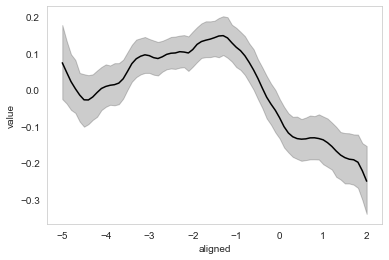

In [30]:
# dem starts

results_day4_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day4.csv")
df_freeze = load.load_behaviour(DATA_DIR, session=SESSION)

events_day4_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing", mouse_col="mouse_name"
).rename(columns={"mouse_name": "mouse"})

traces_day4_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=events_day4_freeze_starts,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=1,
)
traces_day4_freeze_starts = exclude_short_trials(traces_day4_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day4_freeze_starts
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day4_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze starts day4.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.grid(b=None)

plt.savefig("Line freeze starts  day4.svg")


In [32]:
dfp

new_id,406,237,535,531,36,954,638,339,116,151,...,357,186,156,161,534,109,329,350,165,42
aligned,,,,,,,,,,,,,,,,,,,,,
-5.0,-0.773551,-1.017276,-1.569014,-1.711058,-0.269352,-0.059882,0.656676,-2.956208,-1.300152,-0.997362,...,0.308278,-2.726690,-1.589306,-1.082369,-0.924434,1.860336,-1.341178,0.119986,-0.528478,-2.273155
-4.9,-0.816944,-0.959730,-1.860425,-1.655280,-1.050218,-0.407561,-0.085065,-2.174551,-0.191622,-0.430888,...,0.203162,-1.528404,-1.470445,-1.095094,-0.742621,1.869846,-1.484707,-0.344916,-0.823632,-1.652863
-4.8,-0.874091,-0.940106,-2.079956,-1.596850,-1.826274,-0.659365,-0.562531,-1.599434,0.393634,-0.165371,...,0.228849,-0.603868,-1.309752,-1.083683,-0.625186,1.890929,-1.638914,-0.788617,-1.023939,-1.209005
-4.7,-0.955163,-0.962437,-2.198680,-1.571329,-2.102577,-0.757043,-0.544840,-1.407265,0.458071,-0.333558,...,0.435422,-0.294075,-1.176862,-1.054715,-0.465343,1.829784,-1.674592,-0.993666,-1.095880,-1.087090
-4.6,-1.069459,-0.950164,-2.321765,-1.602405,-1.888023,-0.815576,-0.425780,-1.391145,0.425621,-0.583315,...,0.771160,-0.289229,-1.088868,-1.022049,-0.022890,1.686609,-1.590631,-0.959621,-1.185326,-1.053789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.6,1.828413,1.122957,0.254237,1.259069,1.729970,1.846340,-0.455780,1.844384,0.973972,0.685719,...,-2.035346,0.324129,-1.021975,-1.206781,0.344837,-1.615548,0.372856,-0.159782,-0.857055,-0.785903
1.7,1.847217,1.047232,0.202928,1.249666,1.662179,1.801999,-0.703334,2.016971,0.720501,0.846693,...,-2.218702,0.299883,-1.093124,-1.211435,-0.100832,-1.762170,0.395819,-0.197253,-0.946740,-0.945333
1.8,1.866906,0.958922,0.302965,1.181721,1.597096,1.744741,-0.961311,1.979299,0.677713,1.065380,...,-2.363491,0.310425,-1.222218,-1.194668,-0.813120,-1.949994,0.441403,-0.221147,-0.964841,-1.140852


In [31]:
plt.figure()
sns.lineplot(
    data=dfp[coreg_cells].reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="grey",
)
plt.grid(b=None)

plt.savefig(FIG_DIR / "Line freeze starts day4 Coreg only.svg")

KeyError: "['666', '667', '668', '670', '671', '673', '682', '694', '696', '697', '698', '699', '715', '718', '729', '740', '742', '743', '744', '746', '747', '750', '760', '761', '764', '765', '769', '773', '775', '795', '796', '809', '811', '812', '814', '815', '827', '833', '836', '837', '845', '860', '866', '867', '869', '870', '871', '872', '875', '876', '879', '880', '882', '883', '884', '885', '886'] not in index"

<Figure size 432x288 with 0 Axes>

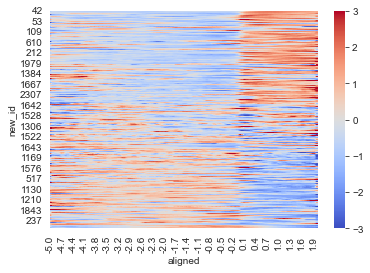

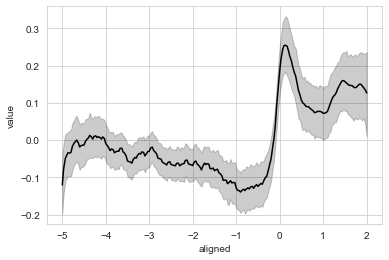

In [ ]:
# dem starts

results_day4_freeze_stops = pd.read_csv(DATA_DIR / "freeze_stops_day4.csv")
df_freeze = load.load_behaviour(DATA_DIR, session=SESSION)

events_day4_freeze_stops = get_freeze_stops(
    df_freeze, freeze_col="was_freezing", mouse_col="mouse_name"
).rename(columns={"mouse_name": "mouse"})

traces_day4_freeze_stops = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=events_day4_freeze_stops,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_stop",
    df_events_group_colname="mouse",
    precision=1,
)
traces_day4_freeze_stops = exclude_short_trials(traces_day4_freeze_stops,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day4_freeze_stops
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day4_freeze_stops.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze stops day4.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.grid(b=None)

plt.savefig("Line freeze stops day4.svg")
